Изучаем задержки рейсов авиакомпаниями. Выявляем благонадёжных и не очень. Ищем причины: возможно виновники всего место, время отправления, день недели или месяц?

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dp = pd.read_csv('C:/Users/elinc/Downloads/airports.csv')
df = pd.read_csv('C:/Users/elinc/Downloads/flights.csv',  dtype=str)
dl = pd.read_csv('C:/Users/elinc/Downloads/airlines.csv', dtype=str)

df = df.loc[~df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)] #Выбросим строки, для которых не указано время отправления или прибытия
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']]) #Создание новой колонки в таблице
df.loc[df.DATE <= pd.to_datetime('2015-02-14')] #Пример использования
df.head()

df.info() #Информация по таблице

df = df.loc[(df.ORIGIN_AIRPORT.apply(len) == 3) &
            (df.DESTINATION_AIRPORT.apply(len) == 3)] #Фильтруем датасет

<class 'pandas.core.frame.DataFrame'>
Index: 5726566 entries, 0 to 5819078
Data columns (total 32 columns):
 #   Column               Dtype         
---  ------               -----         
 0   YEAR                 object        
 1   MONTH                object        
 2   DAY                  object        
 3   DAY_OF_WEEK          object        
 4   AIRLINE              object        
 5   FLIGHT_NUMBER        object        
 6   TAIL_NUMBER          object        
 7   ORIGIN_AIRPORT       object        
 8   DESTINATION_AIRPORT  object        
 9   SCHEDULED_DEPARTURE  object        
 10  DEPARTURE_TIME       object        
 11  DEPARTURE_DELAY      object        
 12  TAXI_OUT             object        
 13  WHEELS_OFF           object        
 14  SCHEDULED_TIME       object        
 15  ELAPSED_TIME         object        
 16  AIR_TIME             object        
 17  DISTANCE             object        
 18  WHEELS_ON            object        
 19  TAXI_IN              objec

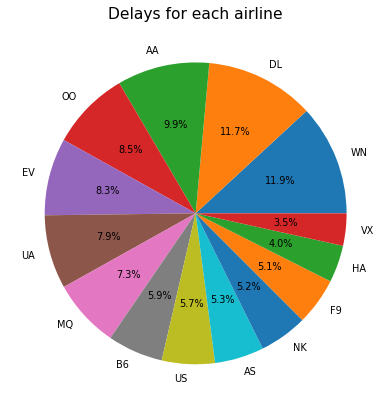

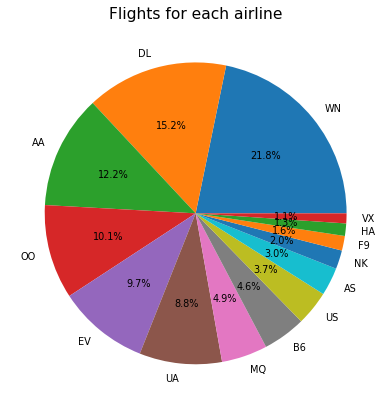

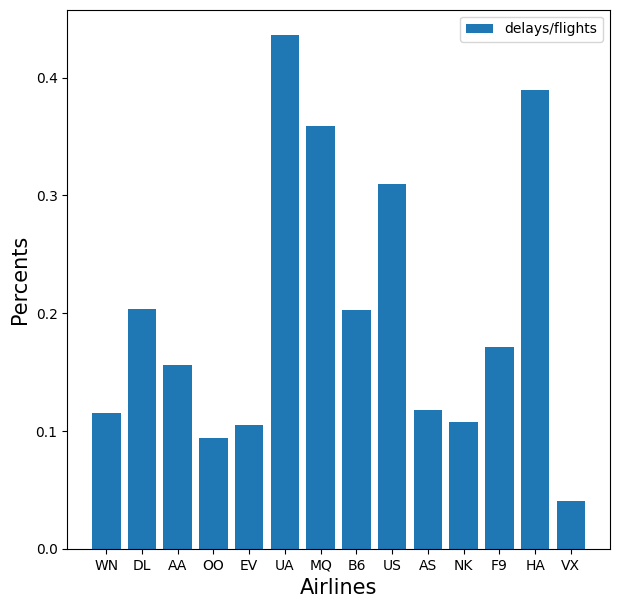

In [50]:
# 1. Рассмотрим у какой компании больше всего задержек, отмен и рейсов в целом относительно других компаний
Z = sum(df.groupby('AIRLINE')['AIRLINE_DELAY'].size())

fig = plt.figure(figsize = (7,7), dpi=70)
plt.title('Delays for each airline', fontsize=16)
plt.pie(100*df.groupby('AIRLINE')['AIRLINE_DELAY'].nunique().sort_values()[::-1]/Z, labels=df.groupby('AIRLINE')['AIRLINE_DELAY'].size().sort_values()[::-1].index, autopct='%1.1f%%')
plt.show()

fig = plt.figure(figsize = (7,7), dpi=70)
Num = sum(df.groupby('AIRLINE').size())
plt.title('Flights for each airline', fontsize=16)
plt.pie(100*df.groupby('AIRLINE').size().sort_values()[::-1]/Num,  labels=df.groupby('AIRLINE').size().sort_values()[::-1].index,   autopct='%1.1f%%')
plt.show()


fig, ax = plt.subplots(figsize=(7, 7))
Hnew = df.groupby('AIRLINE')['AIRLINE_DELAY'].nunique().sort_values()[::-1]/df.groupby('AIRLINE').size().sort_values()[::-1]*100
ax.bar(df.groupby('AIRLINE').size().sort_values()[::-1].index, Hnew,  label = 'delays/flights')
ax.set_ylabel('Percents', fontsize=15)
ax.set_xlabel('Airlines', fontsize=15)
ax.legend()
plt.xticks(df.groupby('AIRLINE').size().sort_values()[::-1].index)
plt.show()

1. WN, DL, AA берут на себя почти треть всех задержек, НО они и совершают половину всех перевозок. Соотвтетственно, соотношении задержки/вылеты показывают неплохой результат, как видно на последнем графике (хотя 20% у DL расстраивает).
Я бы обратила внимание на неблагонадёжные компании UA, HA, MQ и US от 30% до 50% рейсов которых задерживается. Нужно предпринимать меры.

DESTINATION_AIRPORT
DFW    828
ATL    741
ORD    732
DEN    620
LAX    608
      ... 
WYS     43
VEL     41
AKN     35
DLG     34
ITH     25
Name: ARRIVAL_DELAY, Length: 322, dtype: int64


<Axes: xlabel='DESTINATION_AIRPORT'>

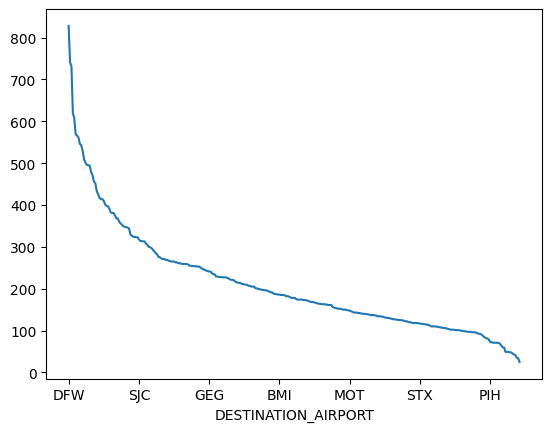

In [74]:
# 2. Возможно, что задержки связаны с местами отправления и назначения. Давайте проверим:
res = df.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].nunique().sort_values()[::-1]
print(res)
res.plot()

ORIGIN_AIRPORT
ATL    566
ORD    560
DFW    514
LAX    512
SFO    505
      ... 
WYS     39
DLG     37
AKN     36
CNY     30
ITH     19
Name: DEPARTURE_DELAY, Length: 322, dtype: int64


<Axes: xlabel='ORIGIN_AIRPORT'>

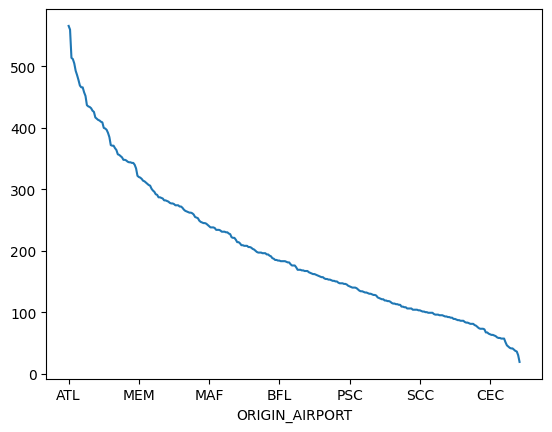

In [75]:
res = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].nunique().sort_values()[::-1]
print(res)
res.plot()

Проблемы с задержками у аэропортов действительно есть. В особенности у ATL, DFW, ORD, DEN, LAX

MONTH
9     570
1     608
4     611
7     616
8     617
11    622
5     632
2     652
3     660
6     695
12    703
Name: DEPARTURE_DELAY, dtype: int64


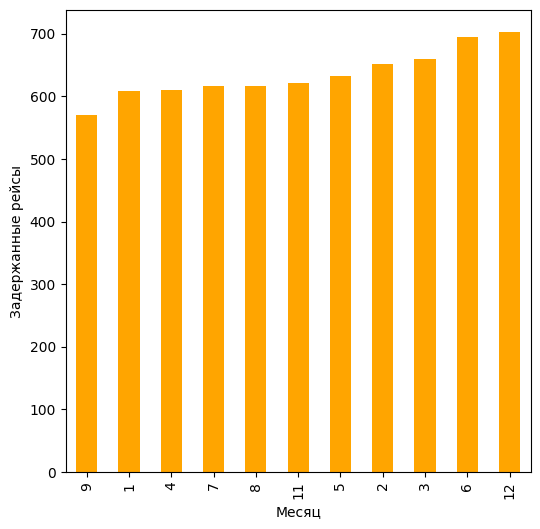

In [102]:
# 3. А может задержки связаны с событиями в мире или сезоном отпусков? Просмотрим динамику по месяцам:
month = df.groupby('MONTH')['DEPARTURE_DELAY'].nunique().sort_values()
print(month)
month.plot.bar(figsize=(6,6),  color = 'orange')
plt.xlabel('Месяц')
plt.ylabel('Задержанные рейсы')
plt.show()

Как видно на графике, наибольшее количество задержек приходится начало лета и Новый год. Возможно, стоит увеличить количество рейсов в это время, но в среднем задержки +- одинаковы.

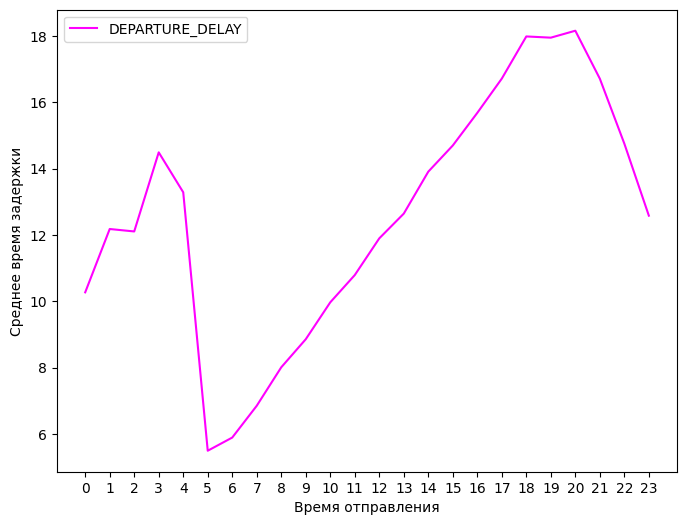

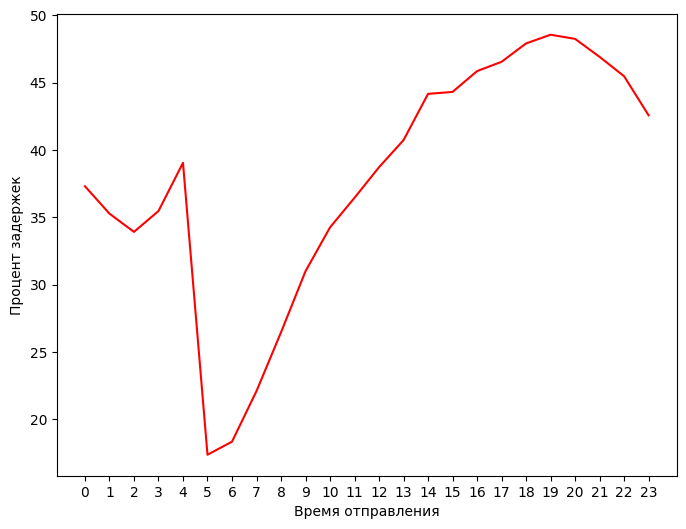

In [100]:
# 4. Тогда, возможно, виновато время отправления?
df['HOUR'] = df.SCHEDULED_DEPARTURE.astype(int)/100
df['HOUR'] = df.HOUR.astype(int)
df['SCHEDULED_DEPARTURE'] = df.SCHEDULED_DEPARTURE.astype(float)
df['DEPARTURE_DELAY'] = df.DEPARTURE_DELAY.astype(float)
df.loc[df.DEPARTURE_DELAY < 0, 'DEPARTURE_DELAY'] = 0
hour = pd.DataFrame(df.groupby('HOUR')['DEPARTURE_DELAY'].mean())
hour.plot(figsize=(8,6), color = 'magenta')
plt.xlabel('Время отправления')
plt.ylabel('Среднее время задержки')
plt.xticks( np.sort(df['HOUR'][df['HOUR'].notna()].unique()))
plt.show()
df.loc[df.DEPARTURE_DELAY > 0, 'HOUR'].value_counts()
number = df.loc[df.DEPARTURE_DELAY > 0, 'HOUR'].value_counts()/df['HOUR'].value_counts()*100
number.plot(figsize=(8,6), color = 'red')
plt.xlabel('Время отправления')
plt.ylabel('Процент задержек')
plt.xticks( np.sort(df['HOUR'][df['HOUR'].notna()].unique()))
plt.show()

Как видно, зависимость прямая. С 18 до 20 наблюдается пик задержек: стоит либо сократить количество рейсов, выставляемых на продажу, чтобы разгрузить аэропорт, либо увеличивать гараж.

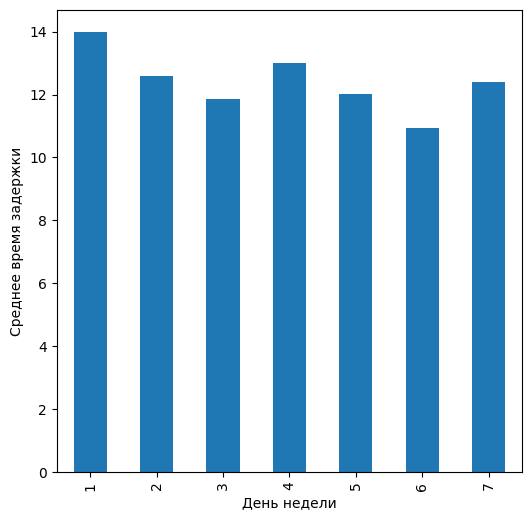

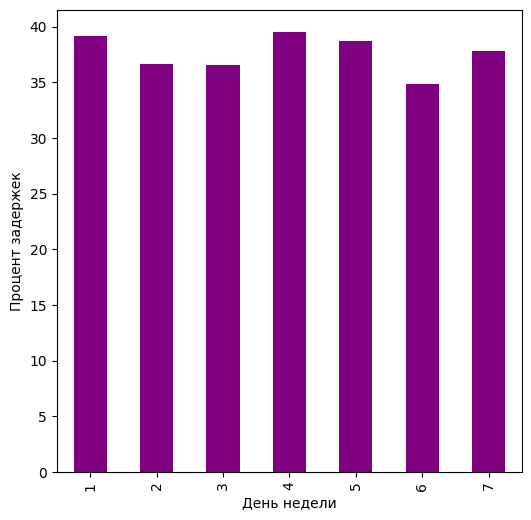

In [119]:
#5 Рассмотрим, в какие дни недели авиакомпании задерживаются меньше всего, и сравним с временем задержек от дней недели.
df['DEPARTURE_DELAY'] = df.DEPARTURE_DELAY.astype(float)
df.loc[df.DEPARTURE_DELAY < 0, 'DEPARTURE_DELAY'] = 0
df.DAY_OF_WEEK = df.DAY_OF_WEEK.astype(int)
day_of_week = df.groupby('DAY_OF_WEEK')['DEPARTURE_DELAY'].mean()
day_of_week.plot.bar(figsize=(6,6))
plt.xlabel('День недели')
plt.ylabel('Среднее время задержки')
plt.show()

df.loc[df.DEPARTURE_DELAY > 0, 'DAY_OF_WEEK'].value_counts()
number_per_week = df.loc[df.DEPARTURE_DELAY > 0, 'DAY_OF_WEEK'].value_counts()/df['DAY_OF_WEEK'].value_counts()*100
number_per_week.plot.bar( figsize=(6,6), color = 'purple')
plt.xlabel('День недели')
plt.ylabel('Процент задержек')
plt.show()

Видим, что зависимость не совсем прямая: наблюдается резкий скачок задержек по четвергам.

Итак, WN, DL, AA берут на себя почти треть всех задержек, НО они и совершают половину всех перевозок. Соотвтетственно, в соотношении задержки/вылеты показывают неплохой результат (хотя 20% задержек у DL расстраивает). Вердикт: WN и AA самые стабильные и благонадёжные из популярных. 
Я бы обратила внимание на неблагонадёжные компании UA, HA, MQ и US: от 30% до 50% их рейсов задерживаются. Нужно предпринимать меры.

На задержки также влияет место прибытия и отправления. Города ATL, DFW, ORD, DEN, LAX показывают наболее высокий уровень задержек. 
Кроме того, наибольшее количество задержек приходится на начало лета и Новый год. Возможно, стоит увеличить количество рейсов в это время.
Как видно, есть прямая зависимость времени отправления и времени задержки. С 18 до 20 наблюдается пик: стоит либо сократить количество рейсов, выставляемых на продажу, чтобы разгрузить аэропорт, либо увеличивать гараж.
По четвергам стоит разгрузить аэропорты: происходит резкий скачок задерже